In [1]:
import mne
import numpy as np

In [2]:
#%% DATA INFO

p = './data/';         # input data folder
subjCodes = ['Sub_1'];  # list of subjects to process
nSub = len(subjCodes);
 
# SELECT SUBJECT TO PROCESS
iSub = 0;

In [3]:
#%% LOAD

fname = p + subjCodes[iSub] + '/' + subjCodes[iSub] + '.set';

print('Loading ...')
eeg = mne.io.read_raw_eeglab(fname, preload=True)

print(subjCodes[iSub] + ' : Loading DONE!')

Loading ...
Reading ./data/Sub_1/Sub_1.fdt
Reading 0 ... 4871599  =      0.000 ...   487.160 secs...
Sub_1 : Loading DONE!


<Info | 7 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, M2, CZ, ...
 chs: 65 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 5000.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 10000.0 Hz
>


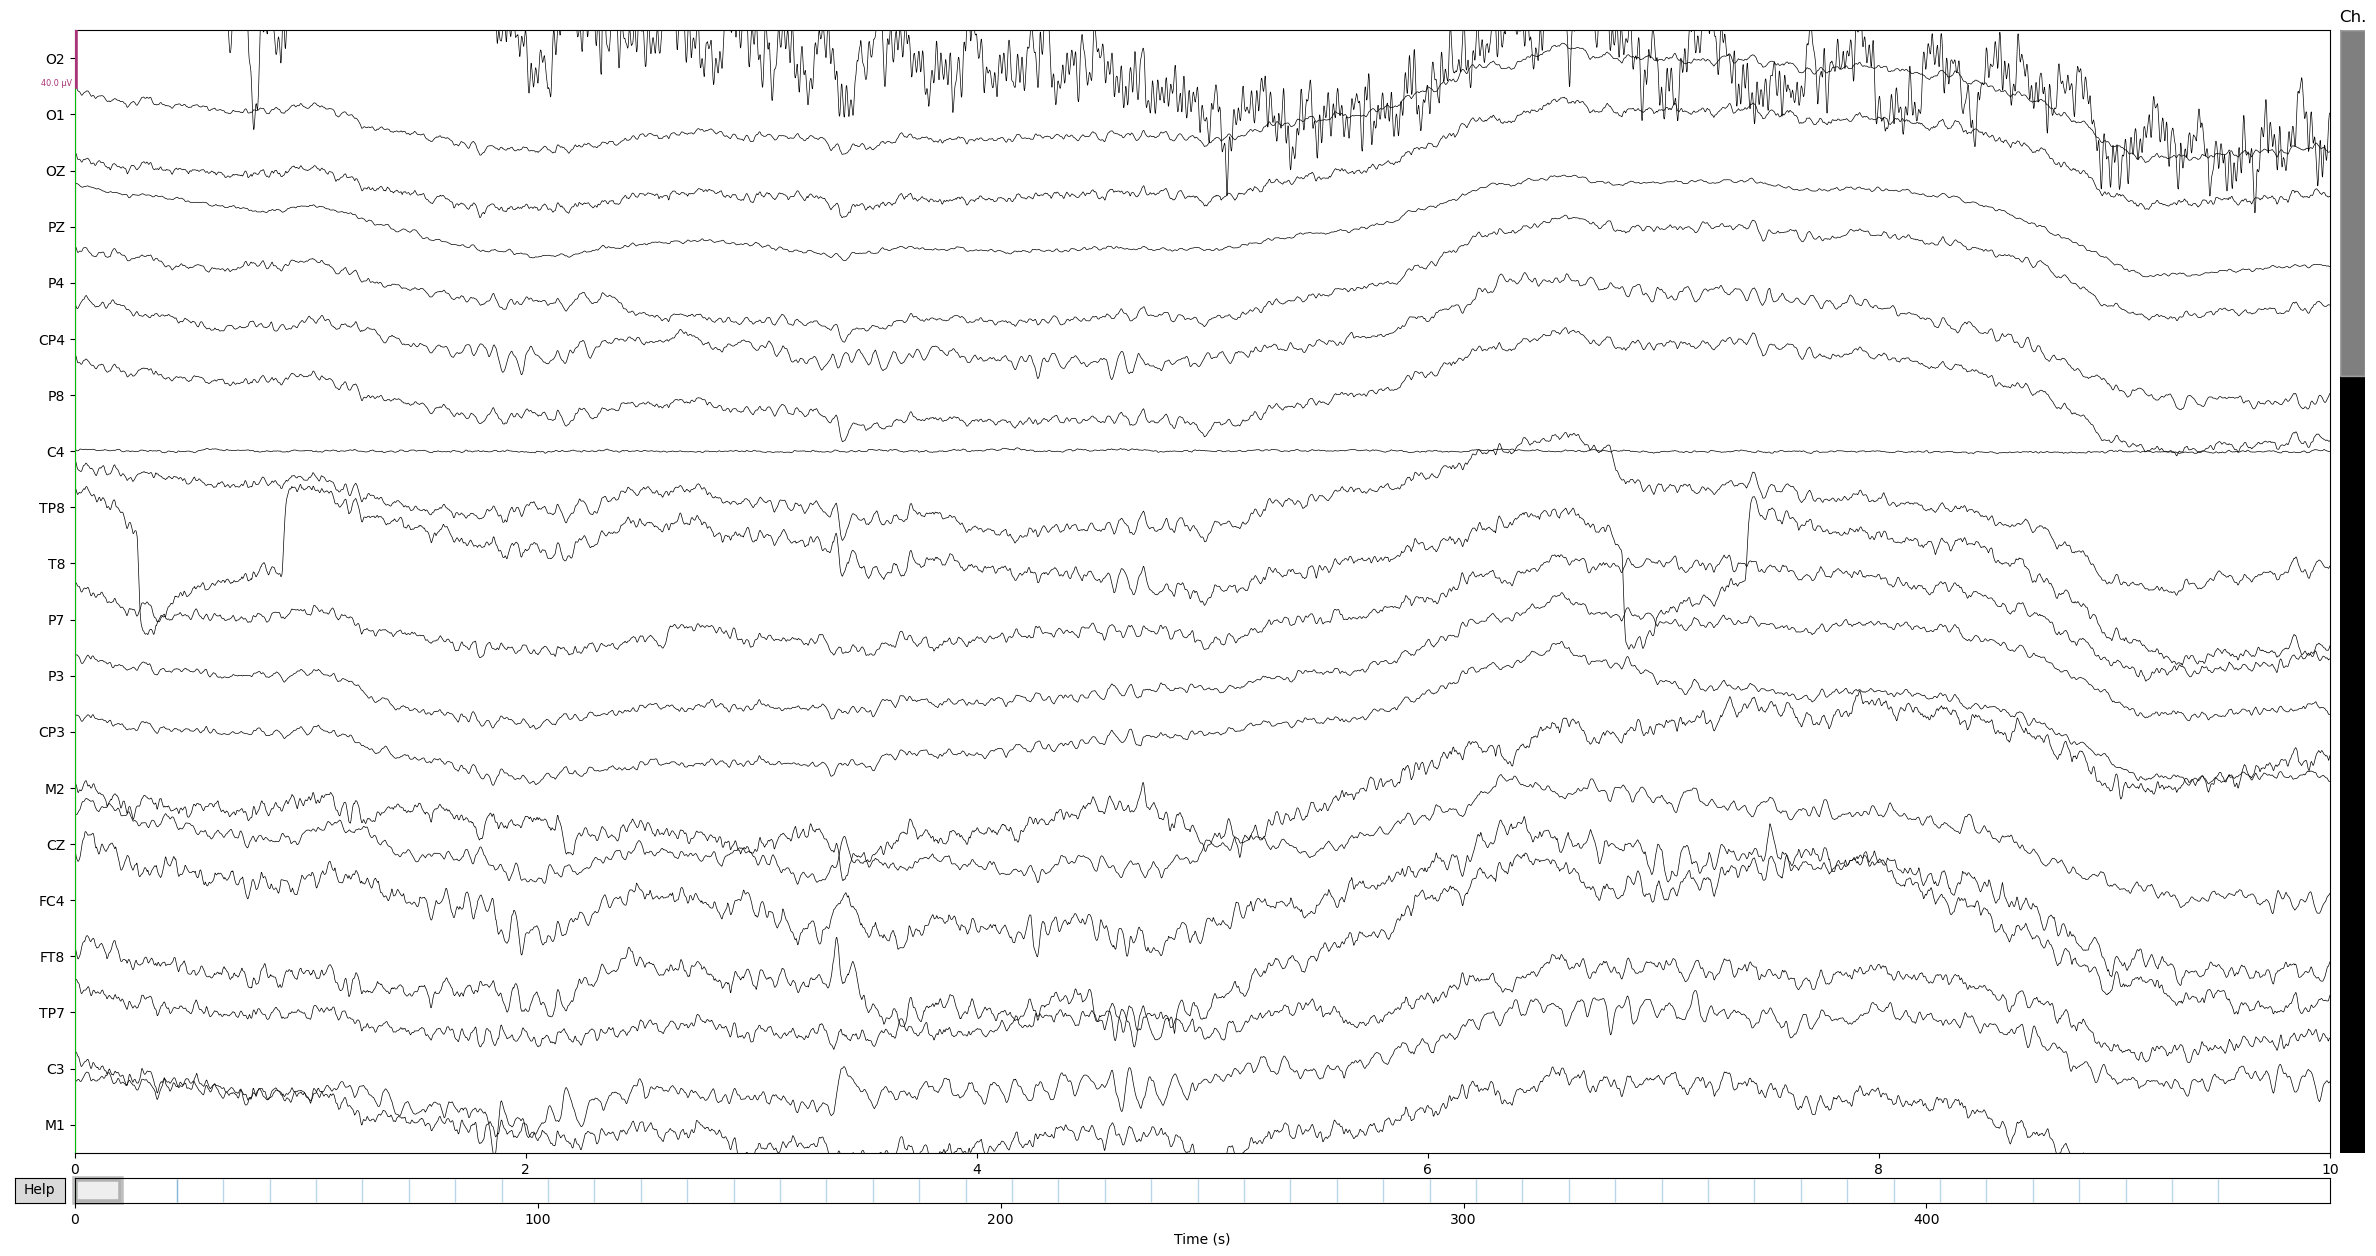

In [4]:
#%% EXPLORE

# view data scroll in detached window, not inline
%matplotlib qt 

print(eeg.info)
eeg.plot()

In [5]:
#%% INITIAL PREPROCESSING:
# - resample to 500 Hz sampling rate
# - delete unused channels
# - set channels location (apply montage)

print('Resampling ...')
eeg = eeg.resample(sfreq=500)

print(subjCodes[iSub] + ' : Resampling DONE!')

Resampling ...
Sub_1 : Resampling DONE!


In [6]:
print('Deleting unused channels ...')
dropChannelsForAll = ['PulseOx', 'EKG', 'VEOG']
eeg = eeg.drop_channels(dropChannelsForAll) # drop PulseOx, EKG and VEOG 
print(subjCodes[iSub] + ' : Dropping channels DONE!')

Deleting unused channels ...
Sub_1 : Dropping channels DONE!


In [7]:
print('Setting chanlocs ...')
montage = mne.channels.read_custom_montage(fname='./data/montages/standard-10-5-cap385.elp')
eeg.set_montage(montage, match_case=False)
print('Setting chanlocs DONE!')

Setting chanlocs ...
Setting chanlocs DONE!


In [8]:
#%% PREPROCESSING:
# - bad channels interpolation

# uncomment to have a look and decide which channels to interpolate
#eeg.plot() # showing bad channels

print('Interpolating bad channels ...')
badChannels = {
    'Sub_1' : ['O2',  'PO3'],
}

eeg.info['bads'] = badChannels[subjCodes[iSub]]
eeg.interpolate_bads()
eeg.info['interpolated'] = badChannels[subjCodes[iSub]]
print('Interpolating bad channels DONE!')

Interpolating bad channels ...
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 2 sensors
Interpolating bad channels DONE!


In [9]:
# check interpolation result
eeg.info['interpolated']

['O2', 'PO3']

BEFORE FILTERING
Effective window size : 4.096 (s)


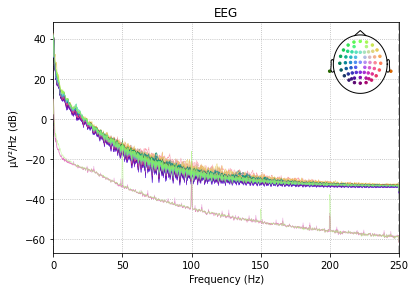

FILTERED 1-70 Hz
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 4.096 (s)


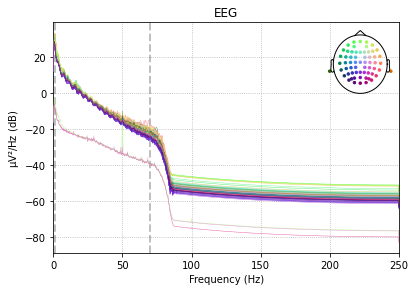

NOTCH FILTER EFFECT (48-52 Hz)
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 sec)

Effective window size : 4.096 (s)


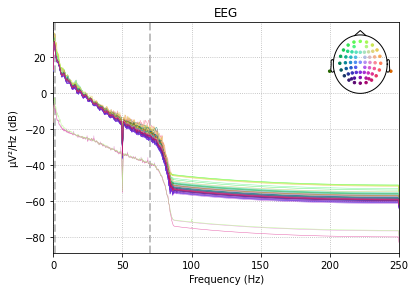

Sub_1 : Filtering DONE!


In [10]:
#%% PREPROCESSING:
# - filtering
# - clean line noise 50 Hz artifact

%matplotlib inline

print("BEFORE FILTERING")
eeg.plot_psd()             # to observe spectrum

eeg_filt = eeg.copy()      # because filter does inplace
print("FILTERED 1-70 Hz")
eeg_filt.filter(l_freq=1, h_freq=70, phase='zero')
eeg_filt.plot_psd()        # to observe power line artifact

print("NOTCH FILTER EFFECT (48-52 Hz)")
eeg_filt.notch_filter(freqs=[50])
eeg_filt.plot_psd()        # end result

print(subjCodes[iSub] + ' : Filtering DONE!')

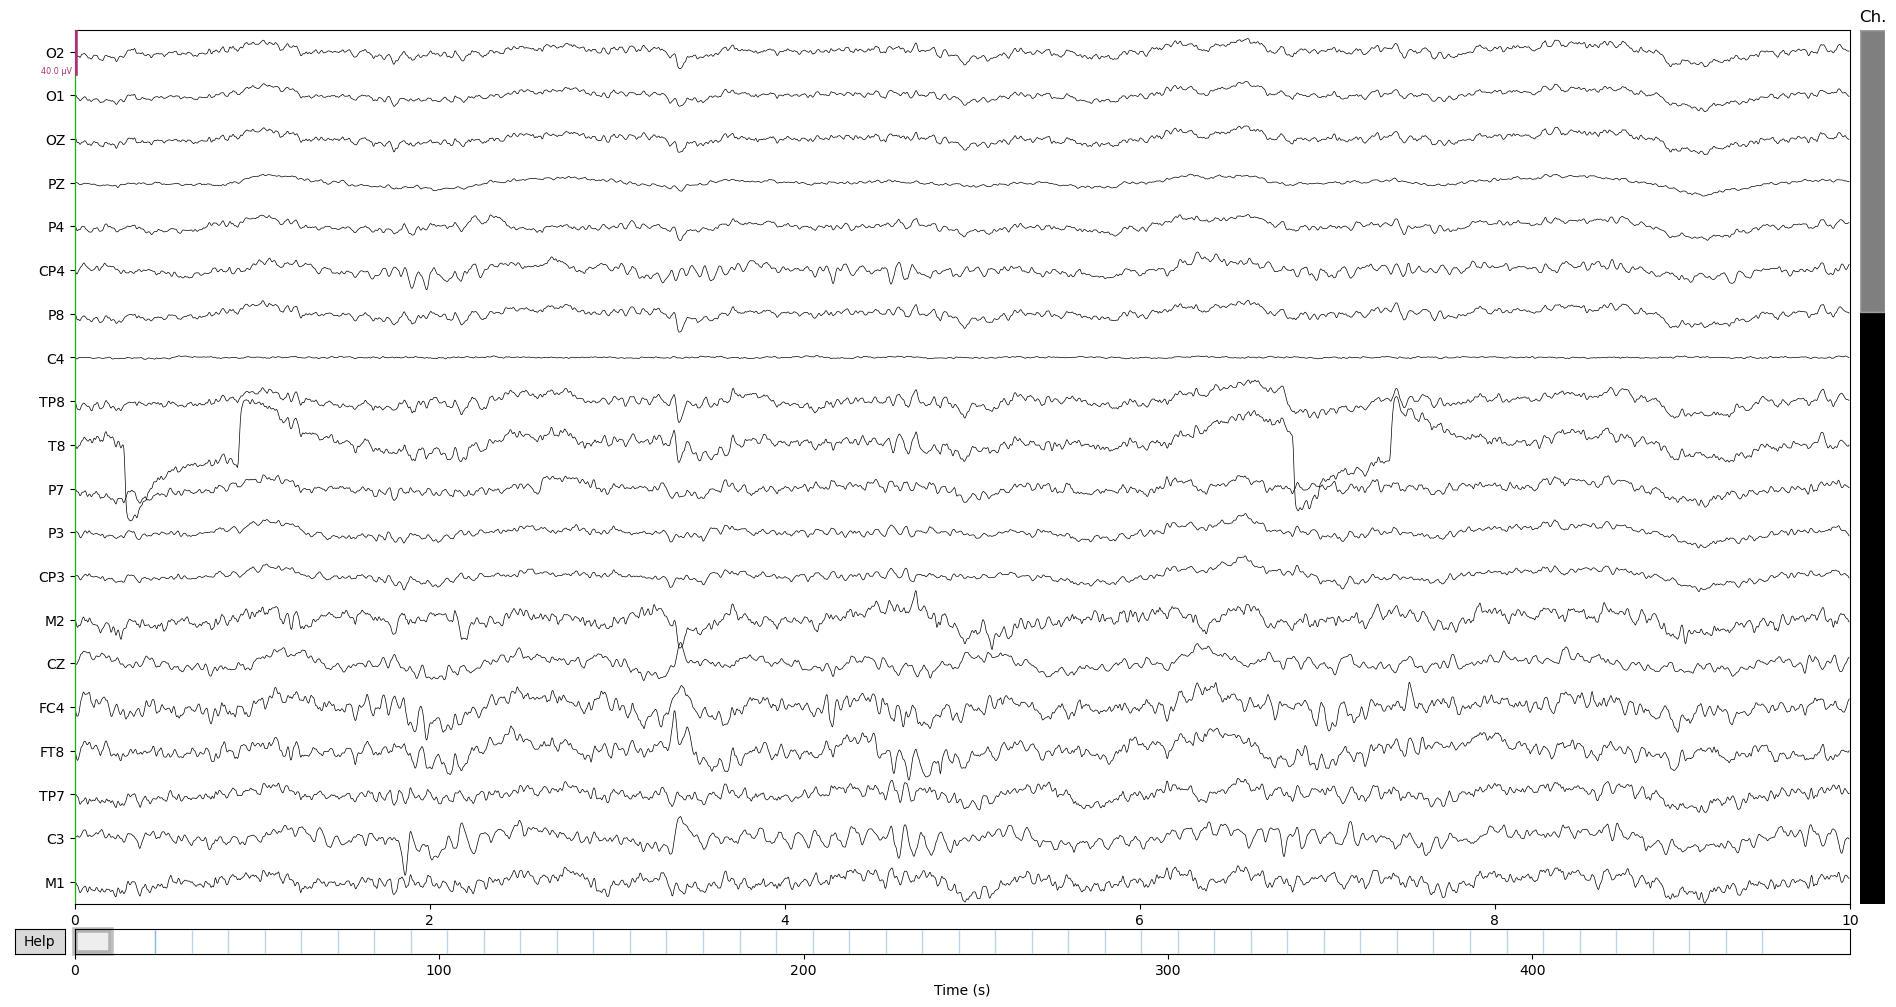

In [11]:
# check filtering result
%matplotlib qt
eeg_filt.plot()

In [12]:
#%% PREPROCESSING:
# - add and correct trial markers

%matplotlib qt

# look at annotations (https://martinos.org/mne/dev/generated/mne.Annotations.html#mne.Annotations)
#print(eeg_filt.annotations.onset)
#print(eeg_filt.annotations.description)
eeg_mrk = eeg_filt.copy()
events = mne.events_from_annotations(eeg_mrk)

# erase first doubled event marker
events = (events[0][1:], events[1])
events

# use python generators to achieve repeating chain of names
import itertools as itt

''' 
sequence of labels:     x - fixation cross on monitor, 
                     lett - letter displayed (word imagery; possible letters: k,l,m, p,r,s)
'''
S1 = ['x']*30 + \
    ['lett/k']*10 + \
    ['lett/l']*10 + \
    ['lett/m']*10 + \
    ['x']*30 + \
    ['lett/p']*10 + \
    ['lett/r']*10 + \
    ['lett/s']*10
    


S2 = ['tictoc/1', 'tictoc/2', 'tictoc/3', 'tictoc/4', 'tictoc/5',
      'tictoc/6', 'tictoc/7', 'tictoc/8', 'tictoc/9', 'ticktoc/10']

# create 1-s events
sfreq = int(eeg_mrk.info['sfreq'])

firstOnsetSamples = int(events[0][0][0]);
lastOnsetSamples = int(events[0][-1][0]);
onsets = np.arange(firstOnsetSamples, lastOnsetSamples, sfreq) # events are in samples not in seconds
nEvents = len(onsets)
durations = np.zeros(nEvents)

# (https://martinos.org/mne/stable/auto_tutorials/intro/plot_object_annotations.html)


# TICTOC EVENTS and ANNOTATIONS (used to epoch data)
tictocCodeGen = itt.cycle(np.arange(101,101+len(S2))) # codes 101 ... 110 generator
tictocCodes = np.asarray(   [ (next(tictocCodeGen)) for n in np.arange(nEvents) ]   )

tictocEventsTiming = np.hstack((onsets.reshape(nEvents,1), 
                           durations.reshape(nEvents,1), 
                           tictocCodes.reshape(nEvents,1)))

tictocEventsCoding = dict(zip(np.arange(101,101+len(S2)),S2))
tictocEvents = [tictocEventsTiming, tictocEventsCoding]
tictocEvents


# convert tictoc events to annotations to plot as regions
ann_onset = tictocEvents[0][:,0] / sfreq
ann_dur = np.repeat(1, len(tictocEvents[0]))
ann_descr = [tictocEvents[1][x] for x in tictocEvents[0][:,2]]
annot_tictoc = mne.Annotations(ann_onset, ann_dur, ann_descr)
eeg_mrk.set_annotations(annot_tictoc)


# CONDITION EVENTS and ANNOTATIONS
# create labeled events (newEvents0 ==events, newEvents1 = event_id)
condEventsCoding = {1:'x', 2:'lett/k', 3:'lett/l', 4:'lett/m', 5:'lett/p', 6:'lett/r', 7:'lett/s'}
condCodeGen = itt.cycle(list(np.repeat(1,30)) + list(np.repeat(2,10)) + list(np.repeat(3,10)) + 
            list(np.repeat(4,10)) + list(np.repeat(1,30)) + list(np.repeat(5,10)) + 
            list(np.repeat(6,10)) + list(np.repeat(7,10)))
condCodes = np.asarray(   [ (next(condCodeGen)) for n in np.arange(nEvents) ]   )

condEventsTiming = np.hstack((onsets.reshape(nEvents,1), 
                           durations.reshape(nEvents,1), 
                           condCodes.reshape(nEvents,1)))
condEvents = [condEventsTiming, condEventsCoding]
condEvents

# convert condition events to annotations to plot as continuous regions
ann_onset = condEvents[0][:,0] / sfreq
ann_dur = np.repeat(1, len(condEvents[0]))
ann_descr = [condEvents[1][x] for x in condEvents[0][:,2]]
annot_cond = mne.Annotations(ann_onset, ann_dur, ann_descr)
eeg_mrk.set_annotations(annot_cond)

eeg_mrk.plot()

print(subjCodes[iSub] + ' : Epoching DONE!')

Used Annotations descriptions: ['10.0']
Sub_1 : Epoching DONE!


In [13]:
#%% PREPROCESSING:
# - epoch data
# - reject bad epochs

condDictReversed = dict([(value, key) for key, value in condEvents[1].items()]) 

epochs = mne.Epochs(eeg_mrk, events=condEvents[0].astype(int), reject=None,
                    event_id=condDictReversed, tmin=0, tmax=1, baseline=None, 
                    proj=False, reject_by_annotation=False, preload=True)


print(epochs)

# Uncomment to examine and decide which epochs will be rejected. 
# Note them in subjectRegionParameters.py
#
#epochs.plot()
#epochs['x'].plot_image('CZ', cmap='interactive')

# showing how to use custom external .py files
import subjectRejectionParameters as subRP

epRejIdx = subRP.epochsToReject_1(subjCodes[iSub]); 
epRejIdx = [x-1 for x in epRejIdx]; # python enumerates from 0

epochs.drop(epRejIdx)
epochs.plot()

print(subjCodes[iSub] + ' : Bad epochs rejection DONE!')

442 matching events found
No baseline correction applied
Not setting metadata
Loading data for 442 events and 501 original time points ...
0 bad epochs dropped
<Epochs  |   442 events (all good), 0 - 1 sec, baseline off, ~104.9 MB, data loaded,
 'lett/k': 40
 'lett/l': 40
 'lett/m': 40
 'lett/p': 30
 'lett/r': 30
 'lett/s': 30
 'x': 232>
Dropped 151 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 

In [14]:
#%% PREPROCESSING:
# - rereference to average
epochs_avgref = epochs.copy()
epochs_avgref, _ = mne.set_eeg_reference(epochs_avgref, 'average', projection=False) # directly re-reference data

# Uncomment to see the result of setting to average reference
#epochs_avgref.plot()

eeg_mrk_avgref = eeg_mrk.copy()
eeg_mrk_avgref, _ = mne.set_eeg_reference(eeg_mrk, 'average', projection=False) # directly re-reference data

print(subjCodes[iSub] + ' : Average reference DONE!')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Sub_1 : Average reference DONE!


In [15]:
#%% PREPROCESSING:
# - Independent Component Analysis (ICA) to clean the signal
# - reject artifact components

from mne.preprocessing import ICA
ica = ICA( method='infomax', 
            fit_params=dict(extended=True), 
            n_components=30, # optionally if you want less than numChannels components
            random_state=123) # set random seed for reproducibility
ic_c = ica.fit(epochs_avgref) # ica on epoched data

ic_c.plot_components(inst=epochs_avgref) # uncomment to plot topographies
#ic_c.plot_sources(inst=epochs_avgref) # uncomment to plot independent component time-courses

print(subjCodes[iSub] + ' : ICA DONE!')

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 30 components
Computing Extended Infomax ICA
Fitting ICA took 49.4s.
Sub_1 : ICA DONE!


In [16]:
# - examine (click on selected topographies) and reject (eye blinks, EKG artifact, muscle noise, etc.) components

bad_components = {'Sub_1' : [0,5,12,15,18,19,20,21,22,23,25,26,27,28,29],
                  } 

ic_c.exclude = bad_components[subjCodes[iSub]]

epochs_ica = epochs_avgref.copy()
eeg_ica = eeg_mrk_avgref.copy()

# apply changes
ic_c.apply(epochs_ica)
ic_c.apply(eeg_ica)

print(subjCodes[iSub] + ' : Rejecting bad ICA components DONE!')

Transforming to ICA space (30 components)
Zeroing out 15 ICA components
Transforming to ICA space (30 components)
Zeroing out 15 ICA components
Sub_1 : Rejecting bad ICA components DONE!


In [19]:
#%% EXAMINE
# Have a look on much cleaner signal

# BEFORE CLEANING
#eeg.plot() 

# AFTER CLEANING
#epochs_ica.plot()  # epoched data 
#eeg_ica.plot()    # continuous signal
#ic_c.plot_components(inst=epochs_avgref) # independent components


[<Figure size 975x942 with 20 Axes>, <Figure size 975x471 with 10 Axes>]

In [20]:
#%% SAVE: ic_c, epochs, epochs_avgref, epochs_ica, 
#       eeg_mrk, eeg_mrk_avgref, eeg_ica, 
#       condEvents, annot_cond
#       bad_channels, bad_components
#       condDictReversed
#       subjCodes, p

# save as separate files
ic_c.save('output/' + subjCodes[iSub] + '_ic_c-ica.fif')
epochs.save('output/' + subjCodes[iSub] + '_epochs-epo.fif', overwrite=True)
epochs_avgref.save('output/' + subjCodes[iSub] + '_epochs_avgref-epo.fif', overwrite=True)
epochs_ica.save('output/' + subjCodes[iSub]+ '_epochs_ica-epo.fif', overwrite=True)

eeg_mrk.save('output/' + subjCodes[iSub] + '_eeg_mrk-raw.fif', overwrite=True)
eeg_mrk_avgref.save('output/' + subjCodes[iSub] + '_eeg_mrk_avgref-raw.fif', overwrite=True)
eeg_ica.save('output/' + subjCodes[iSub] + '_eeg_ica-raw.fif',overwrite=True)


# save as one 'pickled' file
import pickle

DATA_S1_PREPROCESSING = {'condEvents' : condEvents, 
                         'annot_cond' : annot_cond,
                         'dropChannelsForAll': dropChannelsForAll,
                         'badChannels' : badChannels, 
                         'bad_components' : bad_components, 
                         'condDictReversed' : condDictReversed, 
                         'subjCodes' : subjCodes , 
                         'p' : p}
pickle_out = open("output/S1_" + subjCodes[iSub] + ".pickle", "wb")
pickle.dump(DATA_S1_PREPROCESSING, pickle_out)
pickle_out.close()

print(subjCodes[iSub] + ' : SAVE DONE !')

Writing ICA solution to output/Sub_1_ic_c-ica.fif...
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Writing /media/michak/DataDrive/porfolio_github/Python_EEG_Analysis/output/Sub_1_eeg_mrk-raw.fif
Closing /media/michak/DataDrive/porfolio_github/Python_EEG_Analysis/output/Sub_1_eeg_mrk-raw.fif [done]
Overwriting existing file.
Writing /media/michak/DataDrive/porfolio_github/Python_EEG_Analysis/output/Sub_1_eeg_mrk_avgref-raw.fif
Closing /media/michak/DataDrive/porfolio_github/Python_EEG_Analysis/output/Sub_1_eeg_mrk_avgref-raw.fif [done]
Overwriting existing file.
Writing /media/michak/DataDrive/porfolio_github/Python_EEG_Analysis/output/Sub_1_eeg_ica-raw.fif
Closing /media/michak/DataDrive/porfolio_github/Python_EEG_Analysis/output/Sub_1_eeg_ica-raw.fif [done]
Sub_1 : SAVE DONE !
